In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import json
import os

In [23]:
# -----------------------------
# 1. Load and Merge Traffic Data (Jan to June)
# -----------------------------

csv_files = [
    "bzm_telraam_2025_01.csv",
    "bzm_telraam_2025_02.csv",
    "bzm_telraam_2025_03.csv",
    "bzm_telraam_2025_04.csv",
    "bzm_telraam_2025_05.csv",
    "bzm_telraam_2025_06.csv",
]

# Load and merge
dfs = [pd.read_csv(file) for file in csv_files]
df_all = pd.concat(dfs, ignore_index=True)
# Convert date column
df_all["date_local"] = pd.to_datetime(df_all["date_local"], errors='coerce')


In [25]:
# -----------------------------
# 2. Aggregate traffic data by segment
# -----------------------------
agg_df = df_all.groupby("segment_id")[["ped_total", "bike_total", "car_total"]].mean().reset_index()
agg_df.rename(columns={
    "ped_total": "avg_pedestrians",
    "bike_total": "avg_bikes",
    "car_total": "avg_cars"
}, inplace=True)



In [27]:
# -----------------------------
# 3. Load and Parse GeoJSON Safely
# -----------------------------

with open("bzm_telraam_segments.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Extract geometries using first line of each MultiLineString
segment_ids = []
geometry_list = []

for feature in geojson_data["features"]:
    if feature["geometry"]["type"] == "MultiLineString":
        try:
            coords = feature["geometry"]["coordinates"][0]  # Take only first part
            geom = LineString(coords)
            geometry_list.append(geom)
            segment_ids.append(feature["properties"].get("segment_id"))
        except Exception:
            continue
# Create GeoDataFrame with segment_id and geometry
geo_df = gpd.GeoDataFrame({
    "segment_id": segment_ids,
    "geometry": geometry_list
}, crs="EPSG:4326")



<Axes: >

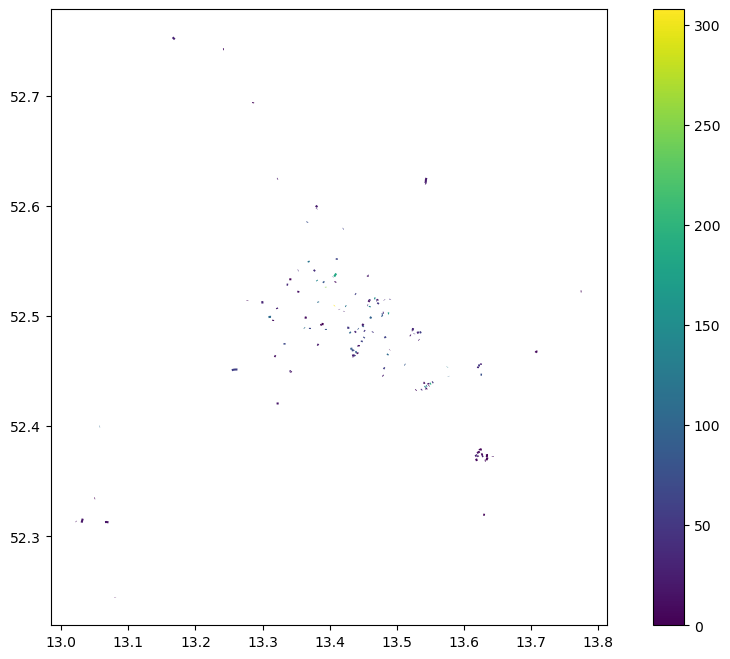

In [29]:

# -----------------------------
# 4. Merge Geometry with Aggregated Traffic
# -----------------------------
merged_gdf = geo_df.merge(agg_df, on="segment_id")

# -----------------------------
# 5. Save or Visualize
# -----------------------------

# Save to GeoJSON or Shapefile
merged_gdf.to_file("berlin_mobility_summary.geojson", driver="GeoJSON")

# OR plot a quick map of average bikes
merged_gdf.plot(column="avg_bikes", cmap="viridis", legend=True, figsize=(12, 8))


In [31]:
merged_gdf.to_file("berlin_mobility_summary.geojson", driver="GeoJSON")

In [33]:
import folium

# Create a Folium map centered on Berlin
m = folium.Map(location=[52.52, 13.405], zoom_start=11)

# Add your traffic segments as colored lines
for _, row in merged_gdf.iterrows():
    folium.GeoJson(row["geometry"], 
                   tooltip=f"Avg bikes: {row['avg_bikes']:.2f}", 
                   style_function=lambda x: {"color": "blue", "weight": 2}).add_to(m)

m.save("berlin_bike_traffic_map.html")


In [41]:
import geopandas as gpd
import folium
from folium import GeoJsonTooltip
from IPython.display import display, IFrame

# Load the processed GeoJSON file
gdf = gpd.read_file("berlin_mobility_summary.geojson")

# Reproject to WGS84 for mapping
gdf = gdf.to_crs(epsg=4326)

# Create a folium map centered on Berlin
m = folium.Map(location=[52.52, 13.405], zoom_start=12, tiles="CartoDB Positron")  # Light street-style map

# Convert GeoDataFrame to GeoJSON format
geojson_data = gdf.__geo_interface__

# Add Choropleth layer for avg_bikes
folium.Choropleth(
    geo_data=geojson_data,
    name='Average Bike Traffic',
    data=gdf,
    columns=['segment_id', 'avg_bikes'],
    key_on='feature.properties.segment_id',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Average Bikes (Jan–June 2025)',
).add_to(m)

# Add interactive tooltips
tooltip = GeoJsonTooltip(
    fields=["segment_id", "avg_bikes", "avg_pedestrians", "avg_cars"],
    aliases=["Segment ID:", "Avg Bikes:", "Avg Pedestrians:", "Avg Cars:"],
    localize=True,
    sticky=True,
    labels=True,
    style="""
        background-color: #2c3e50;
        color: white;
        font-size: 12px;
        padding: 8px;
    """
)

folium.GeoJson(
    geojson_data,
    tooltip=tooltip,
    name="Traffic Segments"
).add_to(m)

# Add Layer Control
folium.LayerControl().add_to(m)

# Save and display the map inline
m.save("berlin_bike_traffic_map.html")
display(IFrame("berlin_bike_traffic_map.html", width="100%", height=600))
